In [1]:
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
import numpy as np
import pandas as pd

In [2]:
ticker_list = ["ETHUSDT"]
start_date = "2022-01-01"
end_date = "2022-01-21"
time_interval = "30m" # try 5, 15, 30, 1hr

In [3]:
# with backtest need Capital OHLCV
p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)
df = p.add_technical_indicator(df, ["stochrsi"], use_stockstats=True)
df.columns = ['time', 'Open', 'High', 'Low', 'Close', 'Volume', 'adj_close', 'tic',
       'stochrsi']
#df = df[['time','close',"stochrsi"]]
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

Succesfully add technical indicators


In [4]:
# From Method 2
def EMA(data, period=20, column='Close'):
    return data[column].ewm(span=period, adjust=False).mean()

def sRSI(data, period=14, column='Close'):
    delta = data[column].diff(1)
    delta = delta.dropna()
    up = delta.copy()
    down = delta.copy()
    up[up<0]=0
    down[down>0]=0
    data['up'] = up
    data['down'] = down
    AVG_Gain = EMA(data, period, column='up')
    AVG_Loss = abs(EMA(data,period,column='down'))
    RS = AVG_Gain / AVG_Loss
    RSI = 100.0 - (100.0/(1.0 + RS))

    sRSI = (RSI-RSI.rolling(period).min()) / (RSI.rolling(period).max() - RSI.rolling(period).min())
    return sRSI * 100

In [5]:
from backtesting import Strategy, Backtest
from backtesting.lib import resample_apply


class System(Strategy):
    d_rsi = 14  # Daily RSI lookback periods
    buy_thresh = 20
    sell_thresh = 80
    
     
    def init(self):
        # sRSI
        #df['sRSI'] = sRSI(df)
        self.sRSI = self.I(sRSI, df)
    
        
    def next(self):
        #print(self.position)
        # reverse price
        #price = self.data.Close[-1]
        #https://algotrading101.com/learn/backtrader-for-backtesting/
        if not self.position:
            #look to make a short/long 
            
            # If sRSI < 20, enter long.
            if self.sRSI < self.buy_thresh:

                # 20% sl 沉得住气...okay maybe not 0.8, try 0.9, try 0.92, no stop loss
                #self.buy(sl=.92 * price)
                self.buy()

            # If sRSI > 80, close position
            # close the position, if any.
            elif self.sRSI > self.sell_thresh:
                self.sell()
        else:
            #we have a position
            if self.position.is_long and self.sRSI > self.sell_thresh:
                #add a decay here
                #close when sRSI > 80 or held for more than 6 hours 
                # (idk how to implement this yet)
                self.position.close()
            elif self.sRSI < self.buy_thresh:
                #a short position:
                self.position.close()

Loading BokehJS ...

In [6]:
# binance 0.1%
backtest = Backtest(df, System, commission=0.001)

Helpful tutorials
https://kernc.github.io/backtesting.py/doc/examples/Quick%20Start%20User%20Guide.html
Next try this:
https://kernc.github.io/backtesting.py/doc/examples/Trading%20with%20Machine%20Learning.html

In [7]:
stats= backtest.run()

In [8]:
backtest.plot()

Row(id='1476', ...)

In [9]:
#These are the trades that would executed with this strategy.
print(stats['_trades'].shape[0])

150


In [10]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-2,21,29,3756.99924,3748.66,16.67848,0.002220,2022-01-01 12:00:00,2022-01-01 16:00:00,0 days 04:00:00
1,2,36,37,3757.59384,3747.00,-21.18768,-0.002819,2022-01-01 19:30:00,2022-01-01 20:00:00,0 days 00:30:00
2,2,38,39,3747.03329,3746.50,-1.06658,-0.000142,2022-01-01 20:30:00,2022-01-01 21:00:00,0 days 00:30:00
3,2,43,44,3728.06434,3730.35,4.57132,0.000613,2022-01-01 23:00:00,2022-01-01 23:30:00,0 days 00:30:00
4,-2,49,58,3743.47278,3742.42,2.10556,0.000281,2022-01-02 02:00:00,2022-01-02 06:30:00,0 days 04:30:00
...,...,...,...,...,...,...,...,...,...,...
145,2,941,942,3084.42134,3089.14,9.43732,0.001530,2022-01-20 16:00:00,2022-01-20 16:30:00,0 days 00:30:00
146,2,943,944,3064.07101,3020.43,-87.28202,-0.014243,2022-01-20 17:00:00,2022-01-20 17:30:00,0 days 00:30:00
147,2,945,946,3004.48148,3022.89,36.81704,0.006127,2022-01-20 18:00:00,2022-01-20 18:30:00,0 days 00:30:00
148,2,948,949,2997.99500,2900.32,-195.35000,-0.032580,2022-01-20 19:30:00,2022-01-20 20:00:00,0 days 00:30:00


In [11]:
# Contains equity/drawdown curves. 
stats['_equity_curve'].tail(40)

,Equity,DrawdownPct,DrawdownDuration
2022-01-20 04:00:00,8383.84189,0.171879,NaT
2022-01-20 04:30:00,8378.32189,0.172424,NaT
2022-01-20 05:00:00,8385.36189,0.171728,NaT
2022-01-20 05:30:00,8403.10189,0.169976,NaT
2022-01-20 06:00:00,8403.10189,0.169976,NaT
2022-01-20 06:30:00,8396.44949,0.170633,NaT
2022-01-20 07:00:00,8396.44949,0.170633,NaT
2022-01-20 07:30:00,8396.44949,0.170633,NaT
2022-01-20 08:00:00,8372.50587,0.172998,NaT
2022-01-20 08:30:00,8313.64587,0.178812,NaT


<AxesSubplot:>

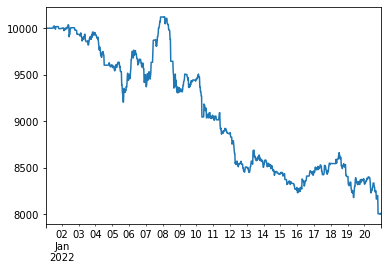

In [12]:
stats['_equity_curve']['Equity'].plot.line()

In [22]:
stats.keys()

Index(['Start', 'End', 'Duration', 'Exposure Time [%]', 'Equity Final [$]',
       'Equity Peak [$]', 'Return [%]', 'Buy & Hold Return [%]',
       'Return (Ann.) [%]', 'Volatility (Ann.) [%]', 'Sharpe Ratio',
       'Sortino Ratio', 'Calmar Ratio', 'Max. Drawdown [%]',
       'Avg. Drawdown [%]', 'Max. Drawdown Duration', 'Avg. Drawdown Duration',
       '# Trades', 'Win Rate [%]', 'Best Trade [%]', 'Worst Trade [%]',
       'Avg. Trade [%]', 'Max. Trade Duration', 'Avg. Trade Duration',
       'Profit Factor', 'Expectancy [%]', 'SQN', '_strategy', '_equity_curve',
       '_trades'],
      dtype='object')

## Resources
- Backtest: https://kernc.github.io/backtesting.py/doc/examples/Strategies%20Library.html

In [13]:
# calculating sRSI

### How to calculate stochastic RSI

$$ sRSI = \frac{RSI-min[RSI]}{max[RSI]-min[RSI]} $$
where: <br>
RSI = current RSI <br>
min[RSI] lowest over past period interval (14) <br>
max[RSI] highest over past period interval (14) <br>

In [14]:
# # Horrible results
# # Method 1 from: https://codingandfun.com/rsi-momentum-strategies-using-python/
# def calc_RSI(stockprices):
#     #calculate the movement on the price compared to the previous day closing price
#     stockprices['movement'] = stockprices['close'] - stockprices['close'].shift(1)

#     stockprices['up'] = np.where((stockprices['movement'] > 0) ,stockprices['movement'],0)

#     stockprices['down'] = np.where((stockprices['movement'] < 0) ,stockprices['movement'],0)

#     window_length = 14
#     #calculate moving average of the last 14 days  gains
#     up = stockprices['up'].rolling(window_length).mean()

#     #calculate moving average of the last 14 days  losses
#     down = stockprices['down'].abs().rolling(window_length).mean()

#     RS = up / down

#     RSI = 100.0 - (100.0 / (1.0 + RS)) 
#     return RSI

# # By definition of formula
# def calc_sRSI(df):
#     RSI = df['rsi']
#     sRSI = (RSI-RSI.rolling(14).min()) / (RSI.rolling(14).max() - RSI.rolling(14).min())
#     return sRSI*100

In [15]:
#df['srsi'] = calc_sRSI(df)

In [16]:
#df['rsi'] = calc_RSI(df)

In [17]:
# # Better but just try to use default from processor
# # Method 2 from: https://www.youtube.com/watch?v=JGB9jm8OWFs
# def EMA(data, period=20, column='close'):
#     return data[column].ewm(span=period, adjust=False).mean()

# def sRSI(data, period=14, column='close'):
#     delta = data[column].diff(1)
#     delta = delta.dropna()
#     up = delta.copy()
#     down = delta.copy()
#     up[up<0]=0
#     down[down>0]=0
#     data['up'] = up
#     data['down'] = down
#     AVG_Gain = EMA(data, period, column='up')
#     AVG_Loss = abs(EMA(data,period,column='down'))
#     RS = AVG_Gain / AVG_Loss
#     RSI = 100.0 - (100.0/(1.0 + RS))

#     sRSI = (RSI-RSI.rolling(period).min()) / (RSI.rolling(period).max() - RSI.rolling(period).min())
#     return sRSI * 100

In [18]:
#df['sRSI'] = sRSI(df)